In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal

%config InlineBackend.figure_format='retina'

In [2]:
img_paths = ["data/c02_s07.png", "data/c06_s01.png", "data/c15_s02.png",
            "data/c10_s07.png", "data/c10_s06.png", "data/c15_s06.png"]

imgs = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in img_paths]

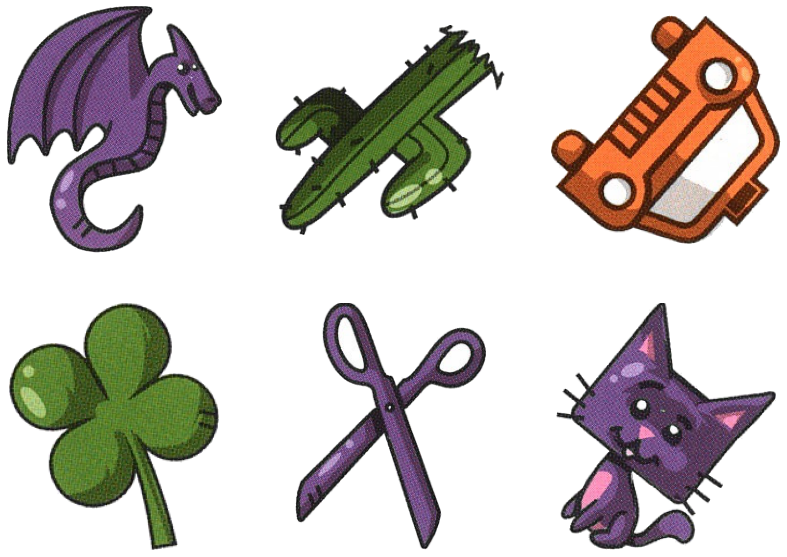

In [3]:
fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for img, ax in zip(imgs, np.nditer(ax_arr, flags=["refs_ok"])):
    ax.item().imshow(img)
    ax.item().set_axis_off()

In [4]:
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

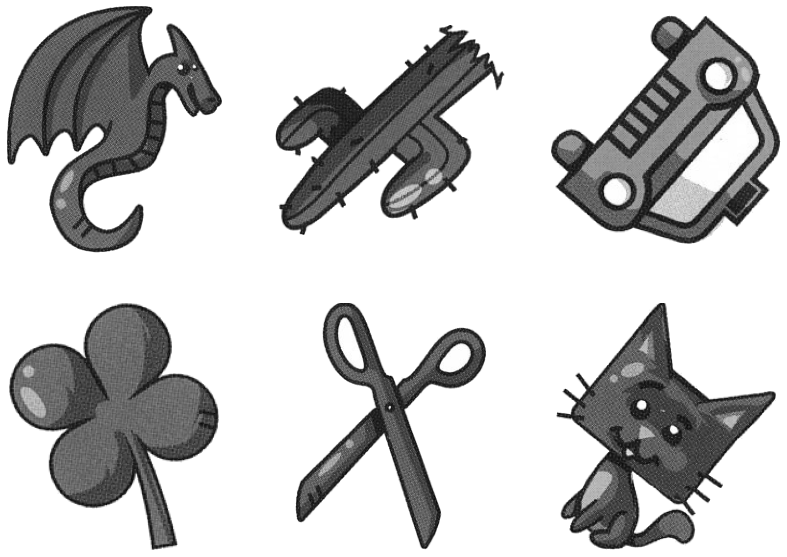

In [5]:
fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for img, ax in zip(imgs_gray, np.nditer(ax_arr, flags=["refs_ok"])):
    ax.item().imshow(img, cmap='gray')
    ax.item().set_axis_off()

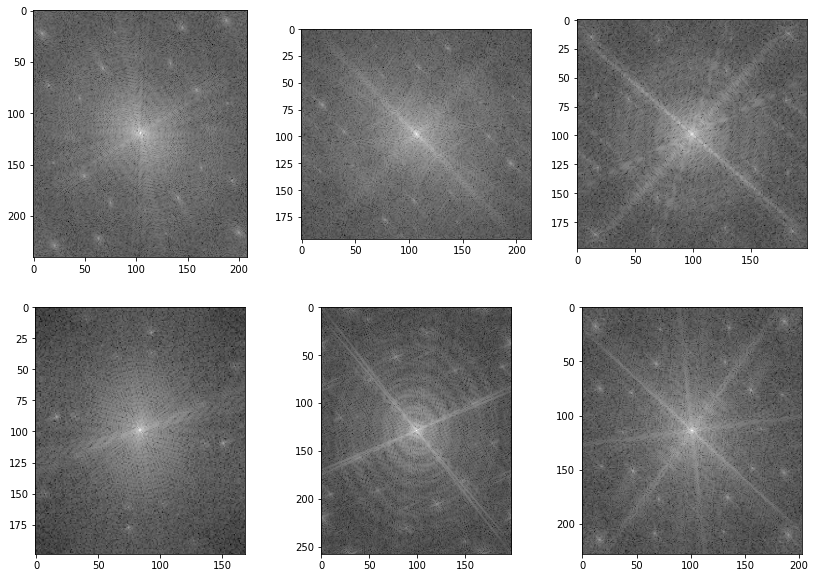

In [6]:
ffts_gray = [np.fft.fftshift(np.fft.fft2(img_gray)) for img_gray in imgs_gray]

fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for fft, ax_ref in zip(ffts_gray, np.nditer(ax_arr, flags=["refs_ok"])):
    ax = ax_ref.item()
    ax.imshow(np.log(np.abs(fft)), cmap='gray')

In [7]:
selected_fft = ffts_gray[0]

In [93]:
car_img = cv2.cvtColor(cv2.imread("data/DeStripe.png"), cv2.COLOR_BGR2GRAY)
car_fft = np.fft.fftshift(np.fft.fft2(car_img))
selected_fft = car_fft

In [94]:
LAPLACIAN_KERNEL = np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1], dtype=float).reshape(
    3, 3
)

def log_abs(ft_coeffs: np.ndarray):
    return np.log10(np.abs(ft_coeffs))

def compute_H_coeffs(log_abs_mat: np.ndarray):
    I_min = np.min(log_abs_mat)
    I_max = np.max(log_abs_mat)

    L = scipy.signal.convolve2d(log_abs_mat, LAPLACIAN_KERNEL, mode="same")

    L_min = np.min(L)
    L_max = np.max(L)

    return (L - L_min) * (log_abs_mat - I_min) / ((L_max - L_min) * (I_max - I_min))

In [95]:
logF = log_abs(selected_fft)
H = compute_H_coeffs(logF)

In [96]:
hist, bins = np.histogram(H, bins=20, range=(0, 1))

In [97]:
hist

array([     1,      0,      0,      0,      0,      0,      0,      0,
           13,    305,   4552,  51136, 134338,  31481,   4485,    264,
            0,      0,      1,      0])

In [98]:
def get_threshold_bin(hist: np.array) -> int:
    null_idx = np.arange(len(hist))[hist == 0]
    group_start_idx = np.hstack(([0], null_idx + 1))
    group_end_idx = np.hstack((null_idx, [hist.shape[0]]))

    group_size = group_end_idx - group_start_idx
    spread_group_idx = np.argmax(group_size)

    spread_group = hist[group_start_idx[spread_group_idx]: group_end_idx[spread_group_idx]]
    max_pop = np.max(spread_group)

    for bin_id, hist_pop in enumerate(spread_group, start=group_start_idx[spread_group_idx]):
        if (hist_pop / max_pop > 0.5):
            thres_bin_id = bin_id
            break

#     bins_id = np.digitize(H, bins) - 1
#     thres_bin = H[bins_id == thres_bin_id]
    
    return thres_bin_id

In [99]:
# def get_sample(H_sample: np.array) -> np.sample:
#     hist, bins = np.histogram(H, bins=20, range=(0, 1))
    
#     thres_bin_id = get_threshold_bin(hist)
#     H_up, H_low = bins[thres_bin_id], bins[thres_bin_id]
#     H_ref = 0.5 * (H_up + H_low)
    
#     I_select = logF[H <= H_ref]
#     max_ref, ave_ref = np.max(I_select), np.mean(I_select)
#     I_ref = 0.5 * (max_ref + ave_ref)
    
    
# get_sample(H)

In [100]:
thres_bin_id = get_threshold_bin(hist)
H_up, H_low = bins[thres_bin_id], bins[thres_bin_id]
H_ref = 0.5 * (H_up + H_low)

In [101]:
# thres_bin = get_threshold_bin(hist)
# H_up, H_low = np.max(thres_bin), np.min(thres_bin)
# H_ref = 0.5 * (H_up + H_low)

In [102]:
I_select = logF[H <= H_ref]
max_ref, ave_ref = np.max(I_select), np.mean(I_select)
I_ref = 0.5 * (max_ref + ave_ref)

In [103]:
Pn1_mask = ((H > H_ref) & (logF > I_ref))
Pn1_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [104]:
Pn1 = np.argwhere(Pn1_mask)

In [105]:
np.bincount(Pn1_mask.flatten())

array([181217,  45359])

In [106]:
np.argwhere(~Pn1)

array([[    0,     0],
       [    0,     1],
       [    1,     0],
       ...,
       [45357,     1],
       [45358,     0],
       [45358,     1]])

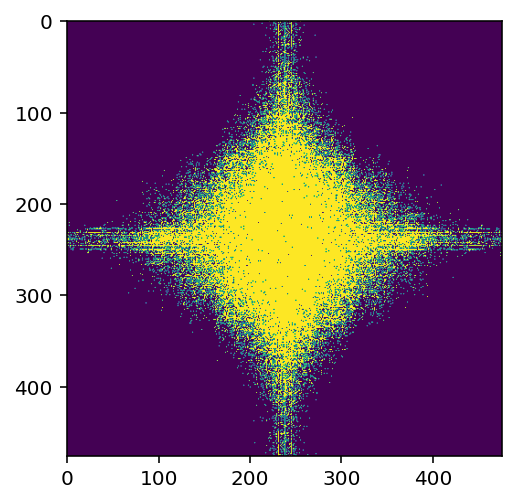

In [107]:
plt.imshow(Pn1_mask)

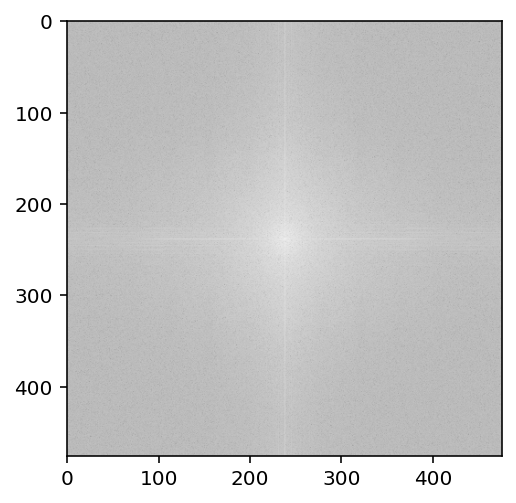

In [108]:
plt.imshow(np.log(np.abs(selected_fft)), cmap='gray')

In [109]:
def compute_eigenvalues(coords: np.ndarray, intensities: np.ndarray):
    y, x = coords.T

    Ixx = np.sum(intensities * y**2)
    Iyy = np.sum(intensities * x**2)
    Ixy = -np.sum(intensities * x * y)

    return np.linalg.eig(np.array([[Ixx, Ixy], [Ixy, Iyy]], dtype=float))


def find_central_area_mask(Pn1_mask: np.ndarray, radius: float):
    shape = Pn1_mask.shape

    Y, X = np.mgrid[0 : shape[0], 0 : shape[1]].astype(float)
    Y -= (shape[0] - 1) / 2
    X -= (shape[1] - 1) / 2
    D = np.sqrt(X**2 + Y**2)

    delta = radius / 10

    center = Pn1_mask[D <= radius]

    while center.sum() / center.size > 0.85:
        radius += delta
        center = Pn1_mask[D <= radius]

    return Pn1_mask & (D <= radius)

In [110]:
fft_center = np.array(selected_fft.shape) / 2

In [111]:
coords = Pn1 - (np.array(selected_fft.shape) - 1) / 2
intensities = logF[Pn1[:, 0], Pn1[:, 1]] / np.sum(logF)

In [112]:
eigenvals, eigenvects = compute_eigenvalues(coords, intensities)

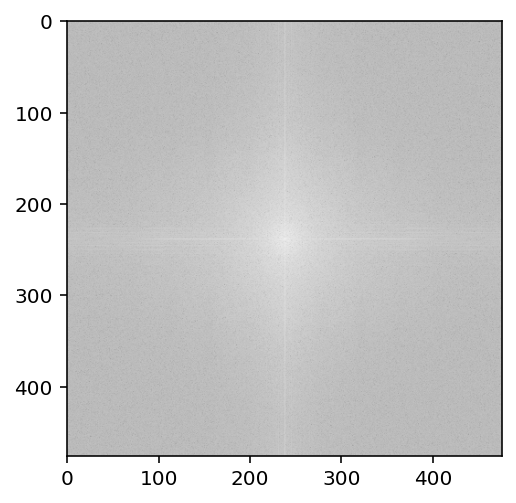

In [113]:
plt.imshow(log_abs(selected_fft), cmap='gray');

In [114]:
eigenvals

array([1379.2962864 , 1190.15388412])

In [115]:
import math
radius = math.sqrt(sum(eigenvals))

In [116]:
radius

50.68974423405785

In [117]:
c0_mask = find_central_area_mask(Pn1_mask, radius)
c0 = np.argwhere(c0_mask)

In [118]:
Pn2_mask = Pn1_mask & ~c0_mask
Pn2 = np.argwhere(Pn2_mask)

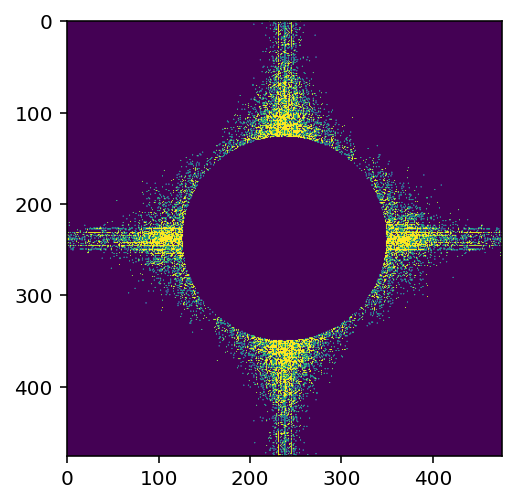

In [119]:
plt.imshow(Pn2_mask)

In [120]:
eigvec_x, eigvec_y = eigenvects
theta = math.acos(np.dot(eigvec_x, eigvec_y)
                  / (np.linalg.norm(eigvec_x) * np.linalg.norm(eigvec_y)))

eig_x, eig_y = eigenvals
eig_x_2 = eig_x * math.cos(theta) ** 2 + eig_y * math.sin(theta) ** 2
eig_y_2 = eig_x * eig_y / eig_x_2

In [121]:
i0, j0 = logF.shape[0] // 2, logF.shape[1] // 2

def f(x: np.array):
    c1, c2 = x
    
    return np.array([
        logF[i, j] / logF[i0, j0] - math.exp(
            - c1 * (i - i0) ** 2 / eig_x_2
            - c2 * (j - j0) ** 2 / eig_y_2
        )
        for i in range(logF.shape[0])
        for j in range(logF.shape[1])
    ])

In [122]:
x0 = [1, 1]
res = scipy.optimize.least_squares(f, x0, method='lm')
res.x

array([0.04417666, 0.0522867 ])

In [123]:
Cn1_mask = (f(res.x).reshape(logF.shape) > 0) & c0_mask
Cn1 = np.argwhere(Cn1_mask)

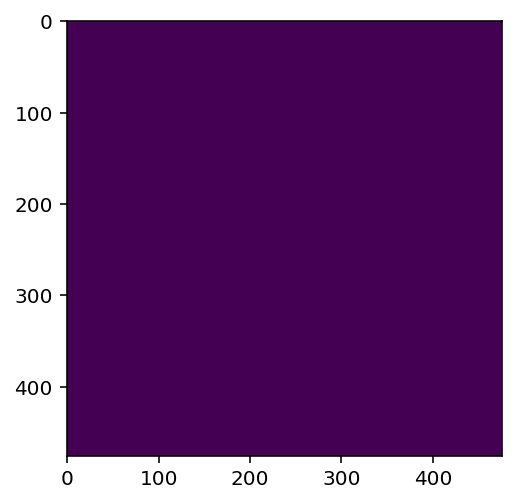

In [124]:
plt.imshow(Cn1_mask)

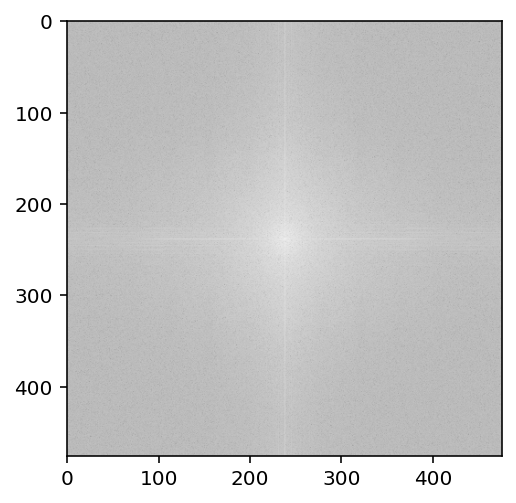

In [125]:
plt.imshow(log_abs(selected_fft), cmap='gray');

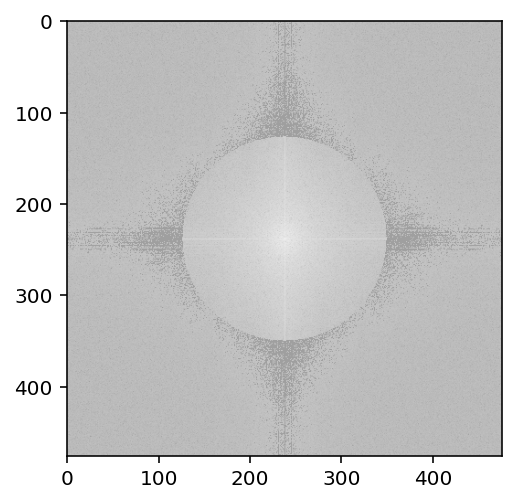

In [126]:
test = selected_fft.copy()
test[Cn1_mask | Pn2_mask] = 1

plt.imshow(log_abs(test), cmap='gray');

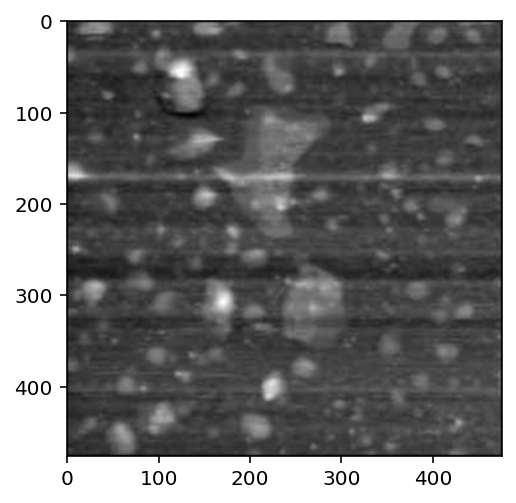

In [127]:
plt.imshow(np.fft.ifft2(np.fft.ifftshift(test)).real, cmap='gray')

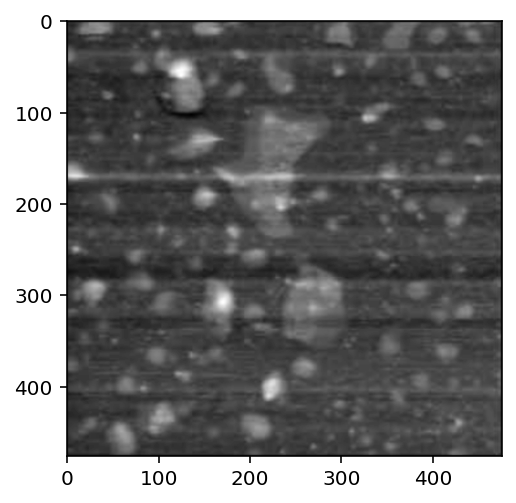

In [128]:
plt.imshow(car_img, cmap='gray')